# Load data

## library

In [172]:
import pandas as pd 
import numpy as np 

In [173]:
train = pd.read_csv('dataset/train.csv', index_col = 'id')
test = pd.read_csv('dataset/test.csv', index_col = 'id')
submission = pd.read_csv('dataset/sample_submission.csv', index_col = 'id')

# Feature Engineering 

## concat train/test

In [174]:
all_data = pd.concat([train, test], ignore_index = True)
all_data = all_data.drop('target', axis = 1)

In [175]:
all_data['title'] = all_data['title'].str.replace('Land Rover' ,'LandRover')

train['title'] = train['title'].str.replace('Land Rover' ,'LandRover')
train['maker'] = [s[:len(s.split()[0])] for s in train['title']]
train['rank'] = train['target'].rank(ascending = False)
train['rank'] = train['rank'].astype(int)
pop_maker = train[train['rank'] < 10]['maker'].unique() # 상위 20위의 차의 브랜드


In [176]:
train['title'].apply(lambda x : x.split()[0])

id
0          Toyota
1          Toyota
2       LandRover
3           Lexus
4          Toyota
          ...    
1010       Toyota
1011       Toyota
1012       Toyota
1013        Lexus
1014          DAF
Name: title, Length: 1015, dtype: object

In [177]:
train['maker'] = train['title'].apply(lambda x : x.split()[0])
train['maker'] = train['maker'].str.replace('Mercedes-Benz/52', 'Mercedes-Benz')


In [178]:
maker_rank = train.groupby('maker')['target'].median().sort_values(ascending = False).to_frame()
maker_rank['rank'] = maker_rank['target'].rank(ascending = False)
maker_rank = maker_rank.to_dict()

In [179]:
all_data['title'] = all_data['title'].str.replace('Land Rover' ,'LandRover')

all_data['maker'] = [s[:len(s.split()[0])] for s in all_data['title']]
all_data['product'] = [s[len(s.split()[0])+1:] for s in all_data['title']]
all_data['maker'] = all_data['maker'].replace({'Mercedes-Benz/52': 'Mercedes-Benz'})


all_data.drop('title', axis = 1, inplace = True)

all_data['transmission'] = all_data['transmission'].map({'automatic' : 0, 'manual' : 1})
all_data['fuel'] = all_data['fuel'].map({'petrol' : 0, 'diesel' : 1})

all_data['isimported'] = all_data['isimported'].map({'New ' : 0,
                                               'Foreign Used' : 1,
                                               'Locally used' : 2})

all_data['engine'] = [s.split('-')[0] for s in all_data['engine']]
all_data['engine'] = all_data['engine'].astype(int)

all_data['location'] = all_data['location'].replace({'Lagos ' : 'Lagos',
                                           'Lagos State' : 'Lagos',
                                           'Abuja ' : 'Abuja',
                                           'Abia State' : 'Abia',
                                           'Ogun State' : 'Ogun'})

all_data['year'] = all_data['year'].replace({1218 : 1998, 1217 : 1997})
all_data['year'] = [2020-s for s in all_data['year']]

all_data['paint'] = [s.lower() for s in all_data['paint']]
all_data['paint'] = [s.strip() for s in all_data['paint']]
all_data['paint'] = [s.replace('.', '') for s in all_data['paint']]
all_data['paint'] = [s.replace('off white l', 'off white') for s in all_data['paint']]
all_data['paint'] = [s.replace('skye', 'sky') for s in all_data['paint']]
all_data['paint'] = [s.replace('redl', 'red') for s in all_data['paint']]


# 비싼 가격의 차 특징

all_data['low_distance'] = [1 if s < 20000 else 0 for s in all_data['odometer']]
all_data['pop_maker'] = [1 if s in pop_maker else 0 for s in all_data['maker']]
all_data['less3y'] = [1 if s < 3 else 0 for s in all_data['year']]
all_data['pop_color'] = [1 if ('white' in s or 'black' in s or s == 'grey') \
                         else 0 for s in all_data['paint']]
all_data['thisyear'] = [1 if s == 2020 else 0 for s in all_data['year']]

all_data['RR'] = [1 if s == 'Rolls-Royce' else 0 for s in all_data['maker']]
all_data['Benz'] = [1 if s == 'Benz' else 0 for s in all_data['maker']]

all_data['distzero'] = [1 if s==0 else 0 for s in all_data['odometer']]
all_data['under100'] = [1 if (s>0 & s<100) else 0 for s in all_data['odometer']]

all_data['maker'] = [s.replace(maker_rank) if s in maker_rank else len(maker_rank)+1 \
                    for s in all_data['maker']]

## One-Hot Encoding

In [180]:
cat_features = ['location', 'paint', 'maker', 'product']
remaining_features =[col for col in all_data.columns if col not in cat_features]

In [181]:
from sklearn.preprocessing import MinMaxScaler

num_train = len(train)
scaler = MinMaxScaler()

scaler.fit(all_data.iloc[:num_train][remaining_features])

X = scaler.transform(all_data.iloc[:num_train][remaining_features])
X = pd.DataFrame(X, columns = remaining_features)

X_test = scaler.transform(all_data.iloc[num_train:][remaining_features])
X_test = pd.DataFrame(X_test, columns = remaining_features)

X = pd.concat([X, X_test])


In [182]:
X = X.reset_index().drop('index', axis = 1)
all_data_cat = all_data[cat_features].reset_index().drop('index', axis = 1)

In [183]:
all_data = pd.concat([X, all_data_cat], axis = 1)

In [184]:
from sklearn.preprocessing import OneHotEncoder 

encoder = OneHotEncoder()
all_cat_encoded = encoder.fit_transform(all_data[cat_features])

all_cat_encoded

<1451x307 sparse matrix of type '<class 'numpy.float64'>'
	with 5804 stored elements in Compressed Sparse Row format>

In [185]:
from scipy import sparse

all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data[remaining_features]),
                               all_cat_encoded],
                              format = 'csr')

In [186]:
num_train = len(train)

X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target'].values
y = np.log(y)

# Training

## 평가지표 함수 생성

In [229]:
def eval_nmae(true, pred, toexp = True):
    
    if toexp : 
        true = np.expm1(true)
        pred = np.expm1(pred)
        
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

## RandomForest

In [266]:
from sklearn.ensemble import RandomForestRegressor

In [267]:
from sklearn.model_selection import KFold


# 층화 K-Fold 교차 검증기 생성
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

# OOF -> 검증 데이터
oof_val_preds = np.zeros(X.shape[0])

# OOF -> 테스트 데이터
oof_test_preds = np.zeros(X_test.shape[0])

# OOF 훈련, 예측 
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)) :
    # 각 폴드 구분
    print('#'*40, f'Fold {idx+1} / Fold {folds.n_splits}' ,'#'*40)
    
    # Split data 
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    # RF training 
    rf_model = RandomForestRegressor(n_estimators = 500)
    rf_model.fit(X_train, y_train)
    
    # OOF prediction using test data 
    oof_test_preds += rf_model.predict(X_test) /folds.n_splits
    
    # OOF prediction using valid data for evaluate performance of model 
    oof_val_preds[valid_idx] += rf_model.predict(X_valid)
    
    # NMAE for pred_proba for valid data 
    nmae_score = eval_nmae(y_valid, oof_val_preds[valid_idx], True)
    
    print(f'Fold {idx+1} NMAE Coef. : {nmae_score}\n')

######################################## Fold 1 / Fold 5 ########################################
Fold 1 NMAE Coef. : 0.30383240204912687

######################################## Fold 2 / Fold 5 ########################################
Fold 2 NMAE Coef. : 0.30999290901095417

######################################## Fold 3 / Fold 5 ########################################
Fold 3 NMAE Coef. : 0.30329798541464775

######################################## Fold 4 / Fold 5 ########################################
Fold 4 NMAE Coef. : 0.25639275573959885

######################################## Fold 5 / Fold 5 ########################################
Fold 5 NMAE Coef. : 0.32332249085312254



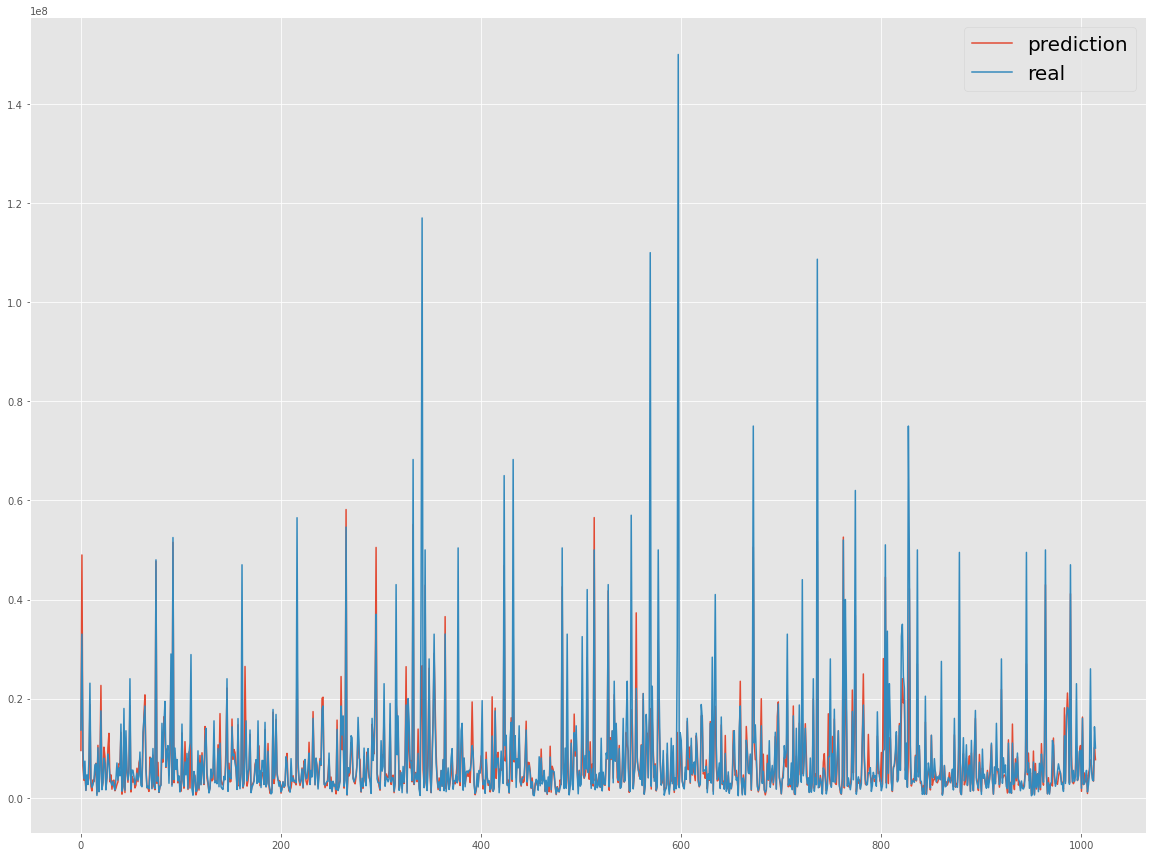

In [268]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(np.exp(oof_val_preds), label = 'prediction')
plt.plot(np.exp(y), label = 'real')
plt.legend(fontsize = 20)
plt.show()

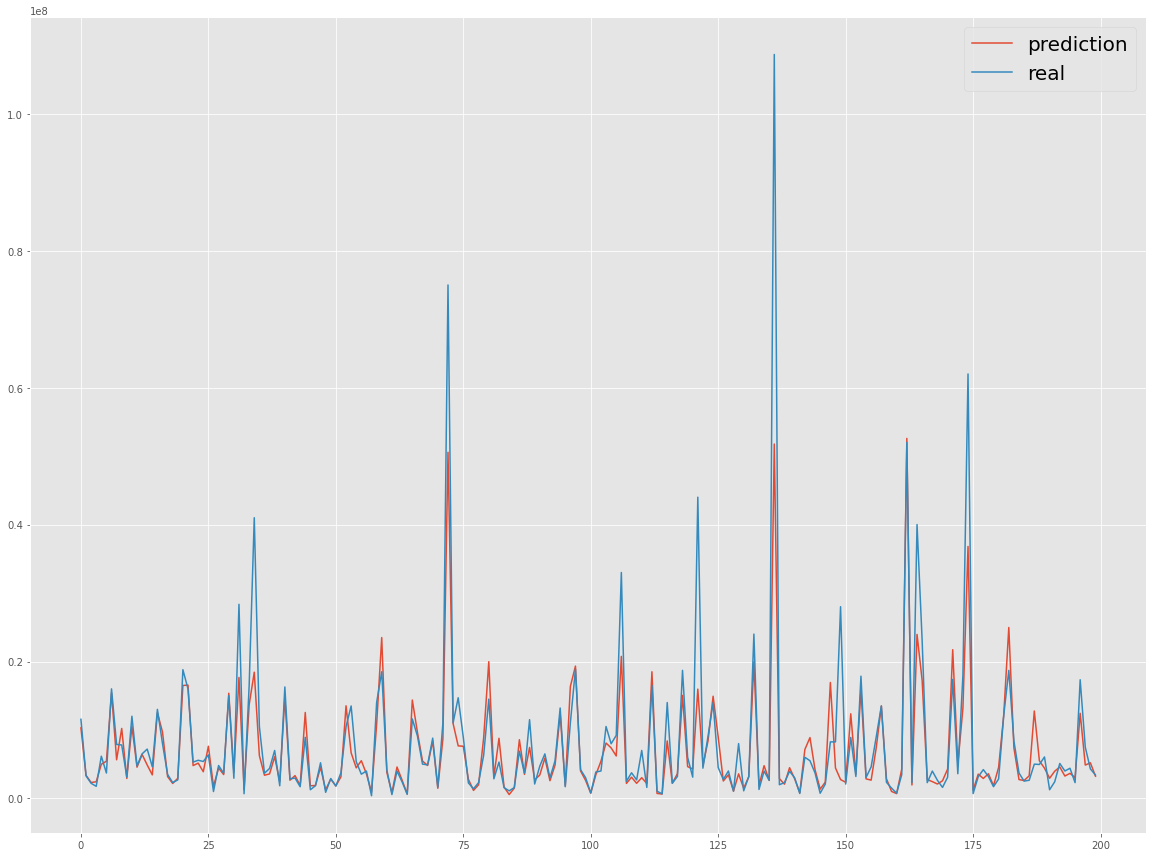

In [269]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(np.exp(oof_val_preds)[600:800], label = 'prediction')
plt.plot(np.exp(y)[600:800], label = 'real')
plt.legend(fontsize = 20)
plt.show()

In [270]:
rf_valid_preds = oof_val_preds
rf_preds = oof_test_preds

## Ridge regression

In [271]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 

nmae_scorer = metrics.make_scorer(eval_nmae, greater_is_better = False)

In [272]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

ridge_model = Ridge()

ridge_params = {'max_iter' : [1000, 2000, 3000],
                'alpha' : [0.1, 0.5, 1, 2, 3, 5], }

gridcv_ridge_model = GridSearchCV(estimator = ridge_model, 
                                  param_grid = ridge_params, 
                                  scoring = nmae_scorer, 
                                  cv = 5)

gridcv_ridge_model.fit(X_train, y_train)

ridge_best_params = gridcv_ridge_model.best_params_

In [273]:
from sklearn.model_selection import KFold


# 층화 K-Fold 교차 검증기 생성
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

# OOF -> 검증 데이터
oof_val_preds = np.zeros(X.shape[0])

# OOF -> 테스트 데이터
oof_test_preds = np.zeros(X_test.shape[0])

# OOF 훈련, 예측 
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)) :
    # 각 폴드 구분
    print('#'*40, f'Fold {idx+1} / Fold {folds.n_splits}' ,'#'*40)
    
    # Split data 
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    # RF training 
    ridge_model = Ridge(**ridge_best_params)
    ridge_model.fit(X_train, y_train)
    
    # OOF prediction using test data 
    oof_test_preds += ridge_model.predict(X_test) /folds.n_splits
    
    # OOF prediction using valid data for evaluate performance of model 
    oof_val_preds[valid_idx] += ridge_model.predict(X_valid)
    
    # NMAE for pred_proba for valid data 
    nmae_score = eval_nmae(y_valid, oof_val_preds[valid_idx], True)
    
    print(f'Fold {idx+1} NMAE Coef. : {nmae_score}\n')

######################################## Fold 1 / Fold 5 ########################################
Fold 1 NMAE Coef. : 0.3155138536194455

######################################## Fold 2 / Fold 5 ########################################
Fold 2 NMAE Coef. : 0.336252225783846

######################################## Fold 3 / Fold 5 ########################################
Fold 3 NMAE Coef. : 0.29266595265866824

######################################## Fold 4 / Fold 5 ########################################
Fold 4 NMAE Coef. : 0.24745502960766796

######################################## Fold 5 / Fold 5 ########################################
Fold 5 NMAE Coef. : 0.3496418737044001



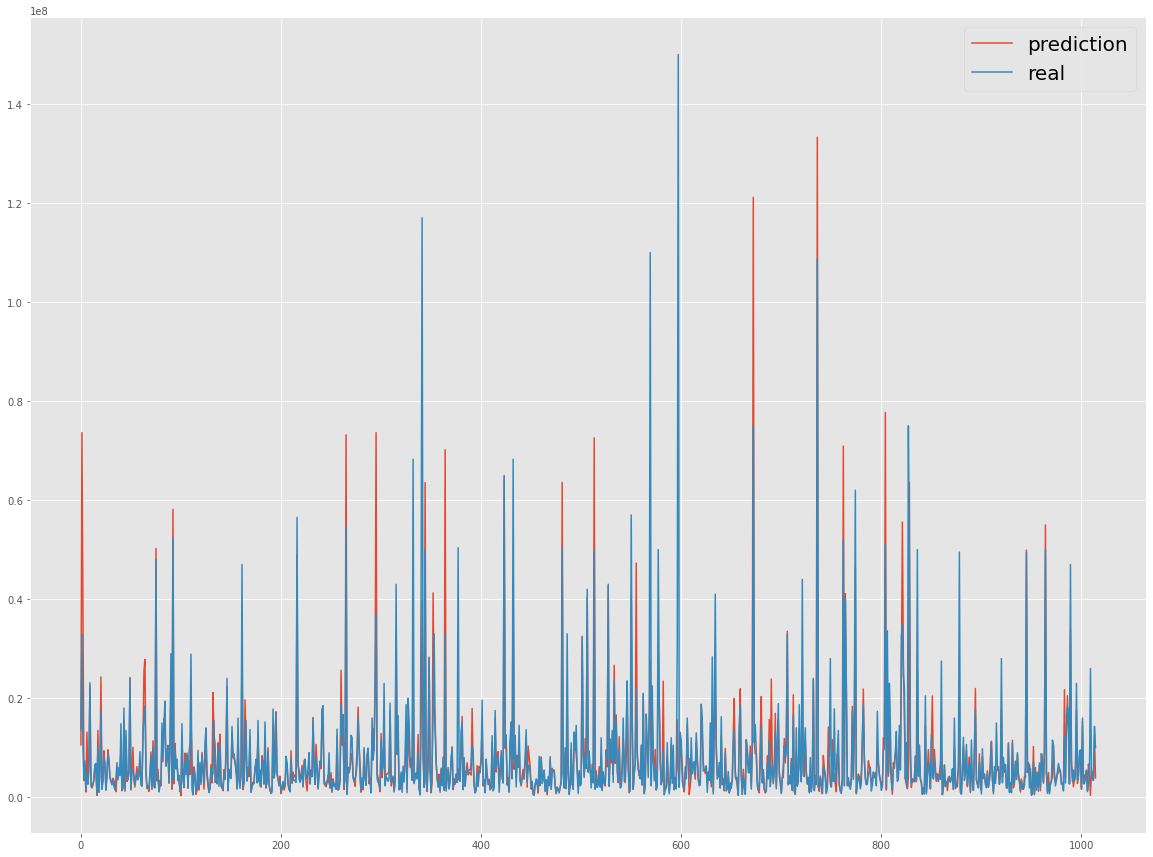

In [274]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(np.exp(oof_val_preds), label = 'prediction')
plt.plot(np.exp(y), label = 'real')
plt.legend(fontsize = 20)
plt.show()

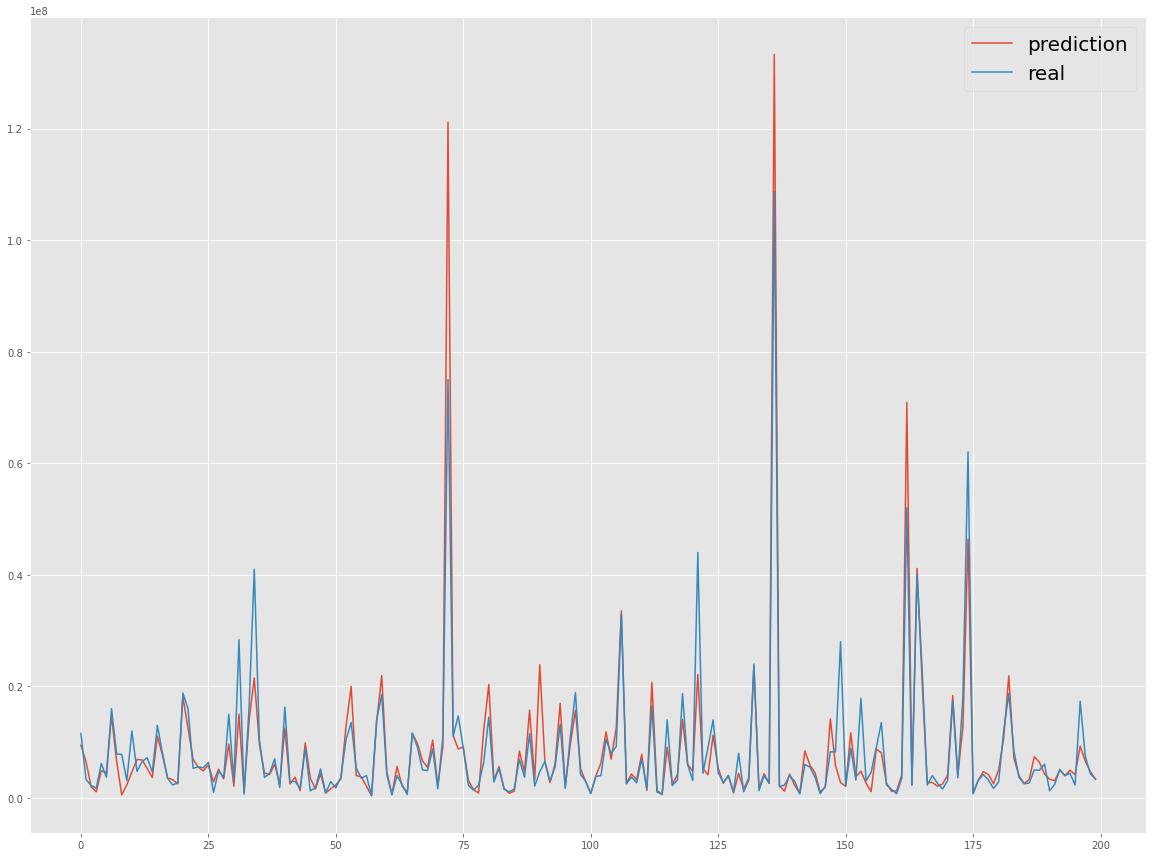

In [275]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(np.exp(oof_val_preds)[600:800], label = 'prediction')
plt.plot(np.exp(y)[600:800], label = 'real')
plt.legend(fontsize = 20)
plt.show()

In [276]:
xgb_valid_preds = oof_val_preds
xgb_preds = oof_test_preds

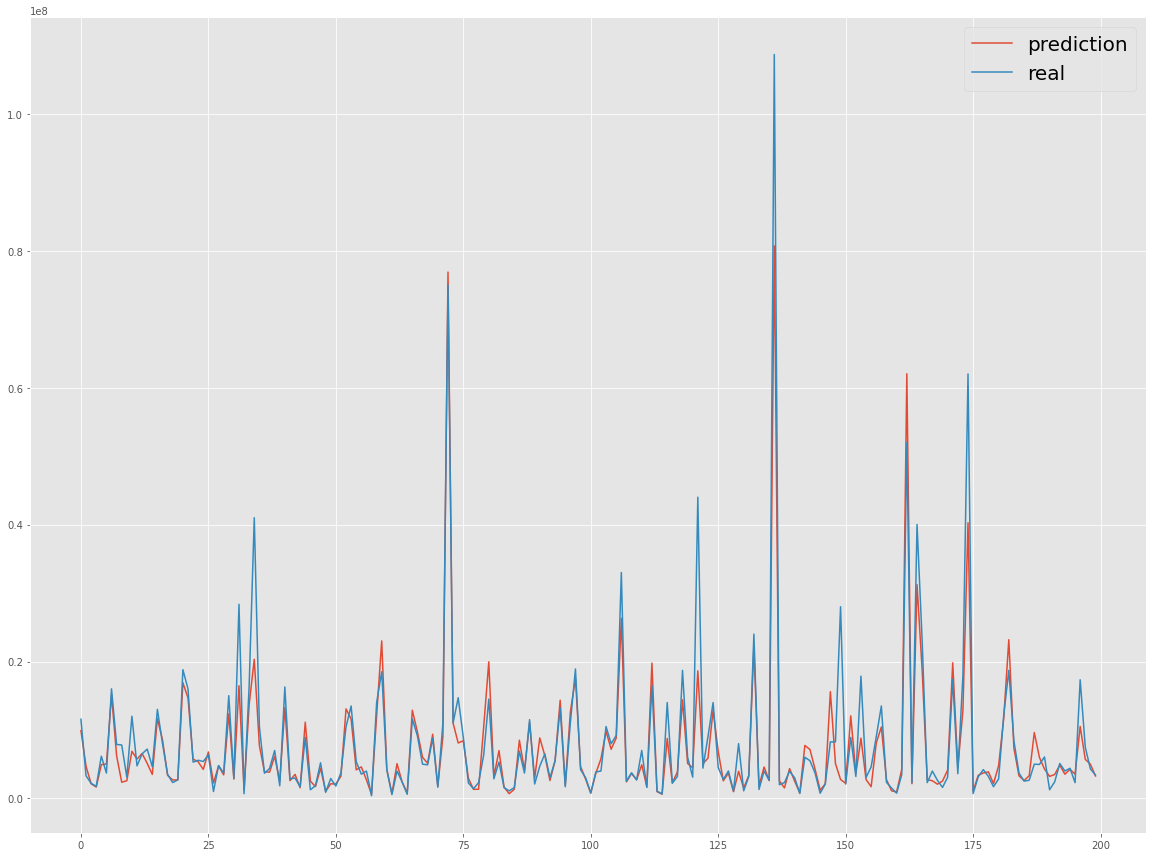

In [277]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(ens[600:800], label = 'prediction')
plt.plot(np.exp(y)[600:800], label = 'real')
plt.legend(fontsize = 20)
plt.show()

## Light GBM

In [278]:
from sklearn.model_selection import KFold


# 층화 K-Fold 교차 검증기 생성
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

# OOF -> 검증 데이터
oof_val_preds = np.zeros(X.shape[0])

# OOF -> 테스트 데이터
oof_test_preds = np.zeros(X_test.shape[0])

# OOF 훈련, 예측 
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)) :
    # 각 폴드 구분
    print('#'*40, f'Fold {idx+1} / Fold {folds.n_splits}' ,'#'*40)
    
    # Split data 
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    # RF training 
    lgb_model = LGBMRegressor(n_estimators = 200)
    lgb_model.fit(X_train, y_train)
    
    # OOF prediction using test data 
    oof_test_preds += lgb_model.predict(X_test) /folds.n_splits
    
    # OOF prediction using valid data for evaluate performance of model 
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid)
    
    # NMAE for pred_proba for valid data 
    nmae_score = eval_nmae(y_valid, oof_val_preds[valid_idx], True)
    
    print(f'Fold {idx+1} NMAE Coef. : {nmae_score}\n')

######################################## Fold 1 / Fold 5 ########################################
Fold 1 NMAE Coef. : 0.35331921483030565

######################################## Fold 2 / Fold 5 ########################################
Fold 2 NMAE Coef. : 0.3417392078106374

######################################## Fold 3 / Fold 5 ########################################
Fold 3 NMAE Coef. : 0.3412081192276024

######################################## Fold 4 / Fold 5 ########################################
Fold 4 NMAE Coef. : 0.2966032061906539

######################################## Fold 5 / Fold 5 ########################################
Fold 5 NMAE Coef. : 0.4131473768849388



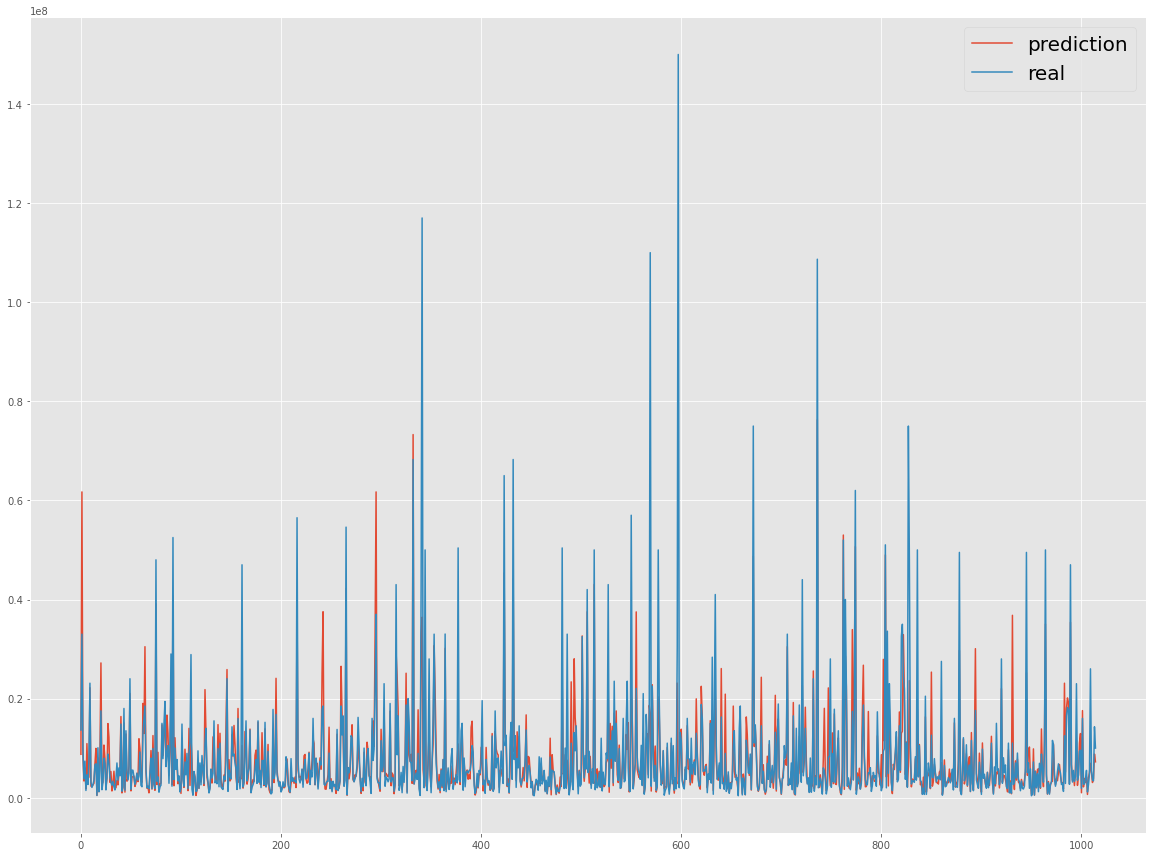

In [279]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(np.exp(oof_val_preds), label = 'prediction')
plt.plot(np.exp(y), label = 'real')
plt.legend(fontsize = 20)
plt.show()

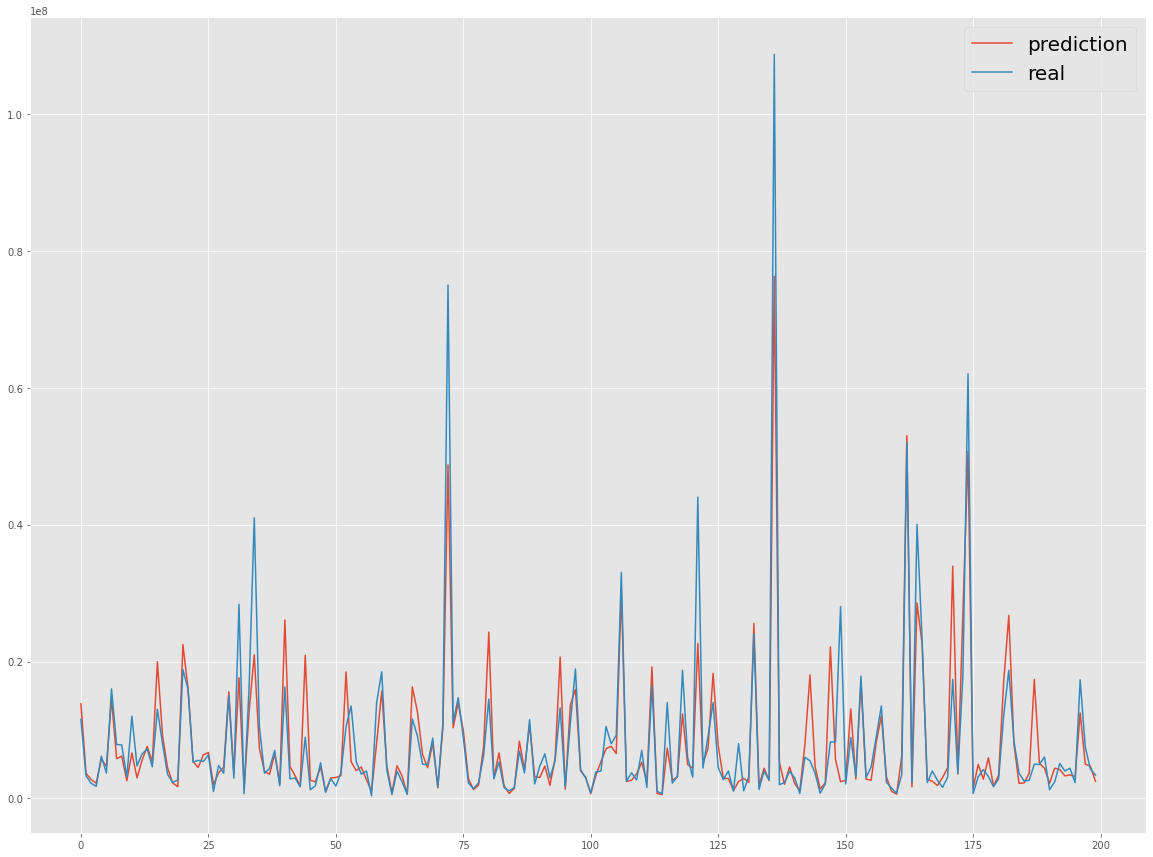

In [280]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(np.exp(oof_val_preds)[600:800], label = 'prediction')
plt.plot(np.exp(y)[600:800], label = 'real')
plt.legend(fontsize = 20)
plt.show()

In [281]:
lgb_valid_preds = oof_val_preds
lgb_preds = oof_test_preds

## GradientBoostingRegressor

In [294]:
from sklearn.model_selection import KFold


# 층화 K-Fold 교차 검증기 생성
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

# OOF -> 검증 데이터
oof_val_preds = np.zeros(X.shape[0])

# OOF -> 테스트 데이터
oof_test_preds = np.zeros(X_test.shape[0])

# OOF 훈련, 예측 
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)) :
    # 각 폴드 구분
    print('#'*40, f'Fold {idx+1} / Fold {folds.n_splits}' ,'#'*40)
    
    # Split data 
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    # RF training 
    gb_model = GradientBoostingRegressor()
    gb_model.fit(X_train, y_train)
    
    # OOF prediction using test data 
    oof_test_preds += gb_model.predict(X_test) /folds.n_splits
    
    # OOF prediction using valid data for evaluate performance of model 
    oof_val_preds[valid_idx] += gb_model.predict(X_valid)
    
    # NMAE for pred_proba for valid data 
    nmae_score = eval_nmae(y_valid, oof_val_preds[valid_idx], True)
    
    print(f'Fold {idx+1} NMAE Coef. : {nmae_score}\n')

######################################## Fold 1 / Fold 5 ########################################
Fold 1 NMAE Coef. : 0.3484534410657713

######################################## Fold 2 / Fold 5 ########################################
Fold 2 NMAE Coef. : 0.32498010930094334

######################################## Fold 3 / Fold 5 ########################################
Fold 3 NMAE Coef. : 0.31574062613055315

######################################## Fold 4 / Fold 5 ########################################
Fold 4 NMAE Coef. : 0.22579346647934614

######################################## Fold 5 / Fold 5 ########################################
Fold 5 NMAE Coef. : 0.3351904992144216



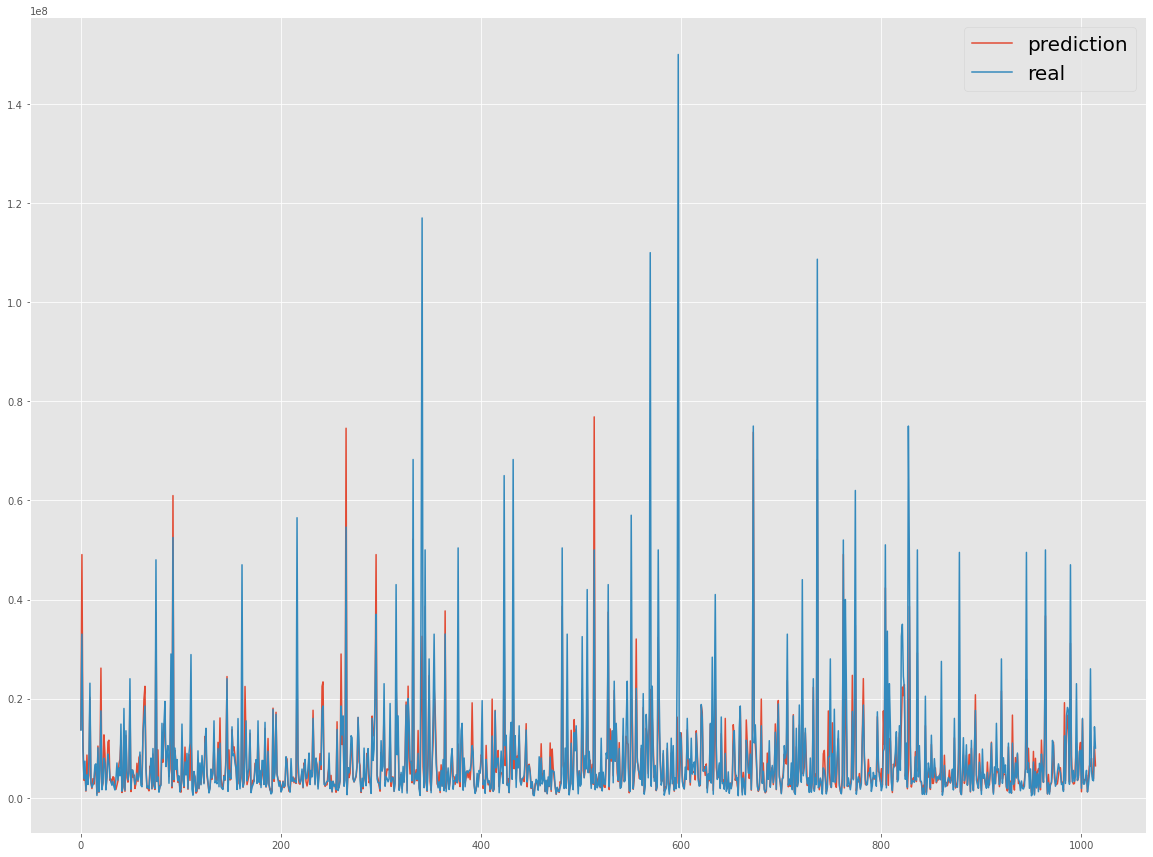

In [295]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(np.exp(oof_val_preds), label = 'prediction')
plt.plot(np.exp(y), label = 'real')
plt.legend(fontsize = 20)
plt.show()

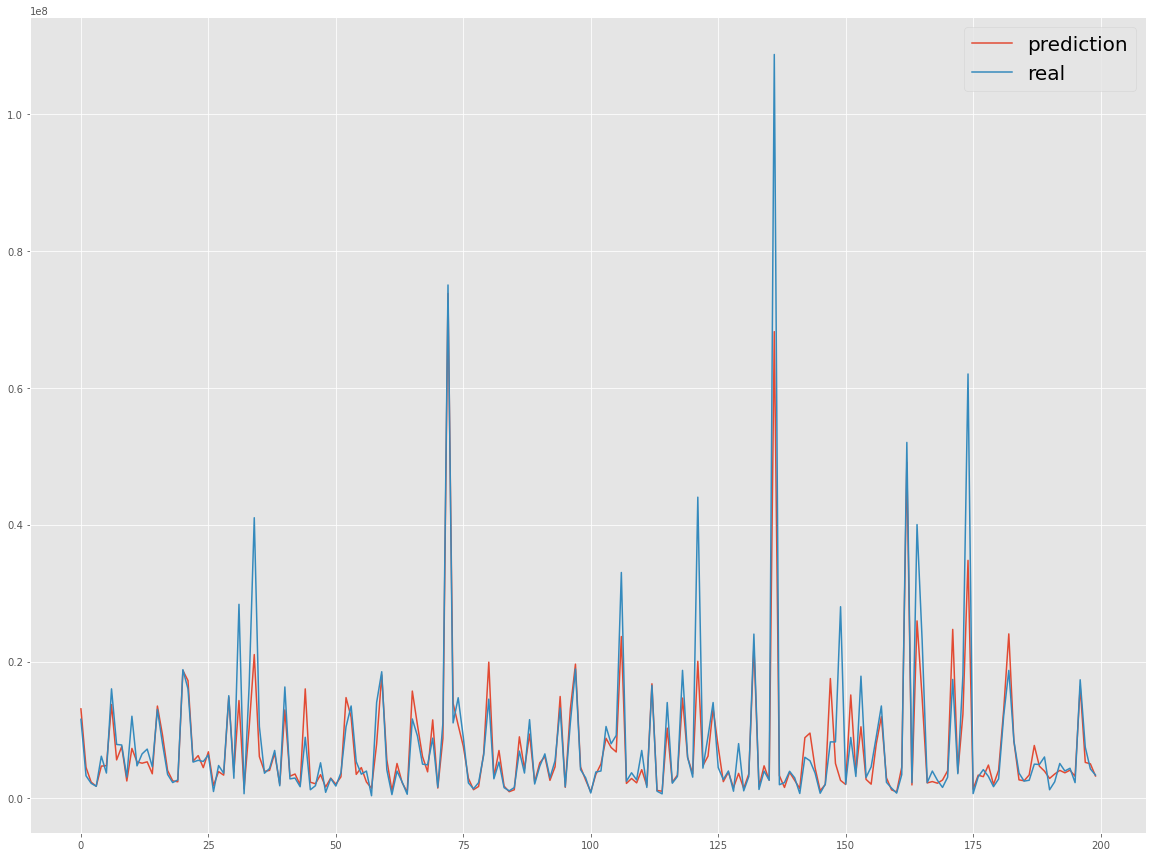

In [296]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(np.exp(oof_val_preds)[600:800], label = 'prediction')
plt.plot(np.exp(y)[600:800], label = 'real')
plt.legend(fontsize = 20)
plt.show()

In [297]:
gb_valid_preds = oof_val_preds
gb_preds = oof_test_preds

## NGBRegressor

In [298]:
from sklearn.model_selection import KFold
from ngboost import NGBRegressor

# 층화 K-Fold 교차 검증기 생성
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

# OOF -> 검증 데이터
oof_val_preds = np.zeros(X.shape[0])

# OOF -> 테스트 데이터
oof_test_preds = np.zeros(X_test.shape[0])

# OOF 훈련, 예측 
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)) :
    # 각 폴드 구분
    print('#'*40, f'Fold {idx+1} / Fold {folds.n_splits}' ,'#'*40)
    
    # Split data 
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    # RF training 
    ngb_model = NGBRegressor(random_state = 42, n_estimators = 1000)
    ngb_model.fit(X_train, y_train)
    
    # OOF prediction using test data 
    oof_test_preds += ngb_model.predict(X_test) /folds.n_splits
    
    # OOF prediction using valid data for evaluate performance of model 
    oof_val_preds[valid_idx] += ngb_model.predict(X_valid)
    
    # NMAE for pred_proba for valid data 
    nmae_score = eval_nmae(y_valid, oof_val_preds[valid_idx], True)
    
    print(f'Fold {idx+1} NMAE Coef. : {nmae_score}\n')

######################################## Fold 1 / Fold 5 ########################################
[iter 0] loss=1.3682 val_loss=0.0000 scale=1.0000 norm=0.9673
[iter 100] loss=0.8261 val_loss=0.0000 scale=2.0000 norm=1.2516
[iter 200] loss=0.4338 val_loss=0.0000 scale=2.0000 norm=1.0668
[iter 300] loss=0.2138 val_loss=0.0000 scale=1.0000 norm=0.5127
[iter 400] loss=0.1205 val_loss=0.0000 scale=1.0000 norm=0.5178
[iter 500] loss=0.0566 val_loss=0.0000 scale=2.0000 norm=1.0384
[iter 600] loss=0.0146 val_loss=0.0000 scale=1.0000 norm=0.5160
[iter 700] loss=-0.0218 val_loss=0.0000 scale=1.0000 norm=0.5080
[iter 800] loss=-0.0527 val_loss=0.0000 scale=2.0000 norm=1.0072
[iter 900] loss=-0.0822 val_loss=0.0000 scale=1.0000 norm=0.4987
Fold 1 NMAE Coef. : 0.32387947843957837

######################################## Fold 2 / Fold 5 ########################################
[iter 0] loss=1.3992 val_loss=0.0000 scale=1.0000 norm=0.9871
[iter 100] loss=0.7959 val_loss=0.0000 scale=2.0000 norm=1.2

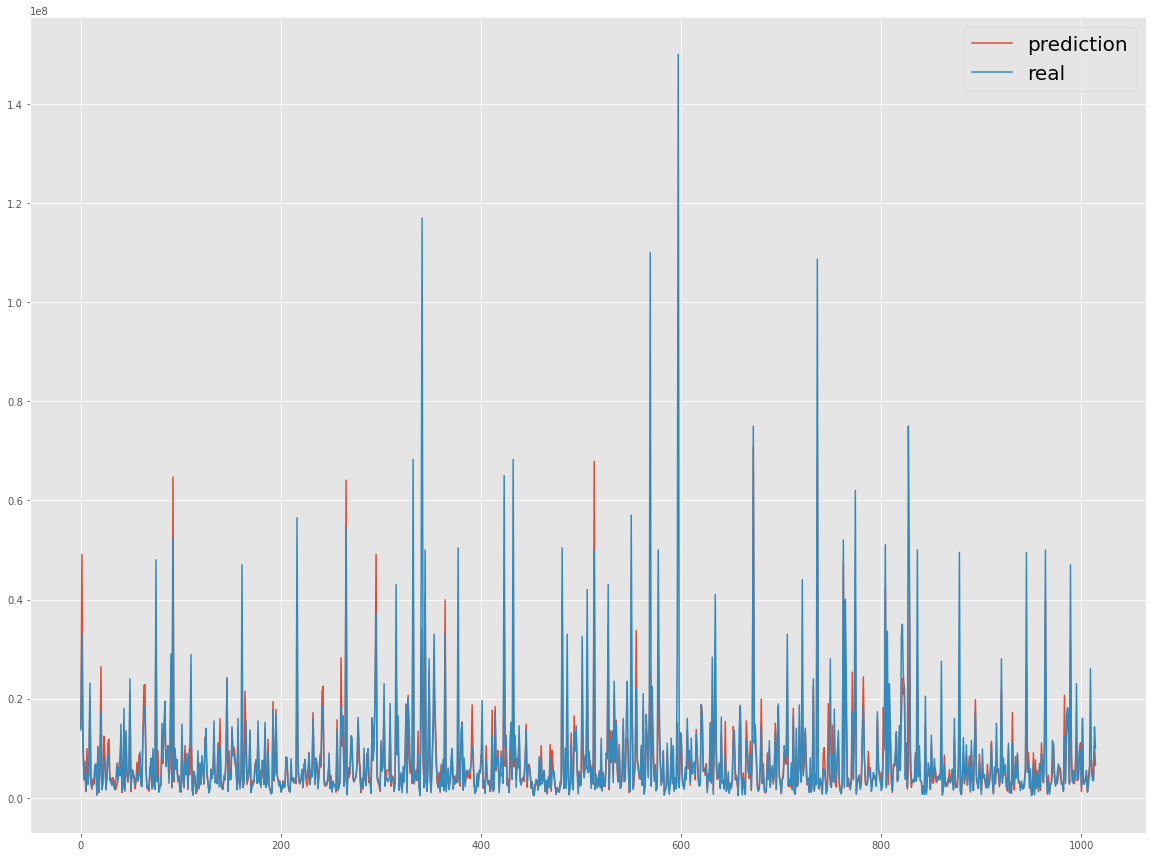

In [299]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(np.exp(oof_val_preds), label = 'prediction')
plt.plot(np.exp(y), label = 'real')
plt.legend(fontsize = 20)
plt.show()

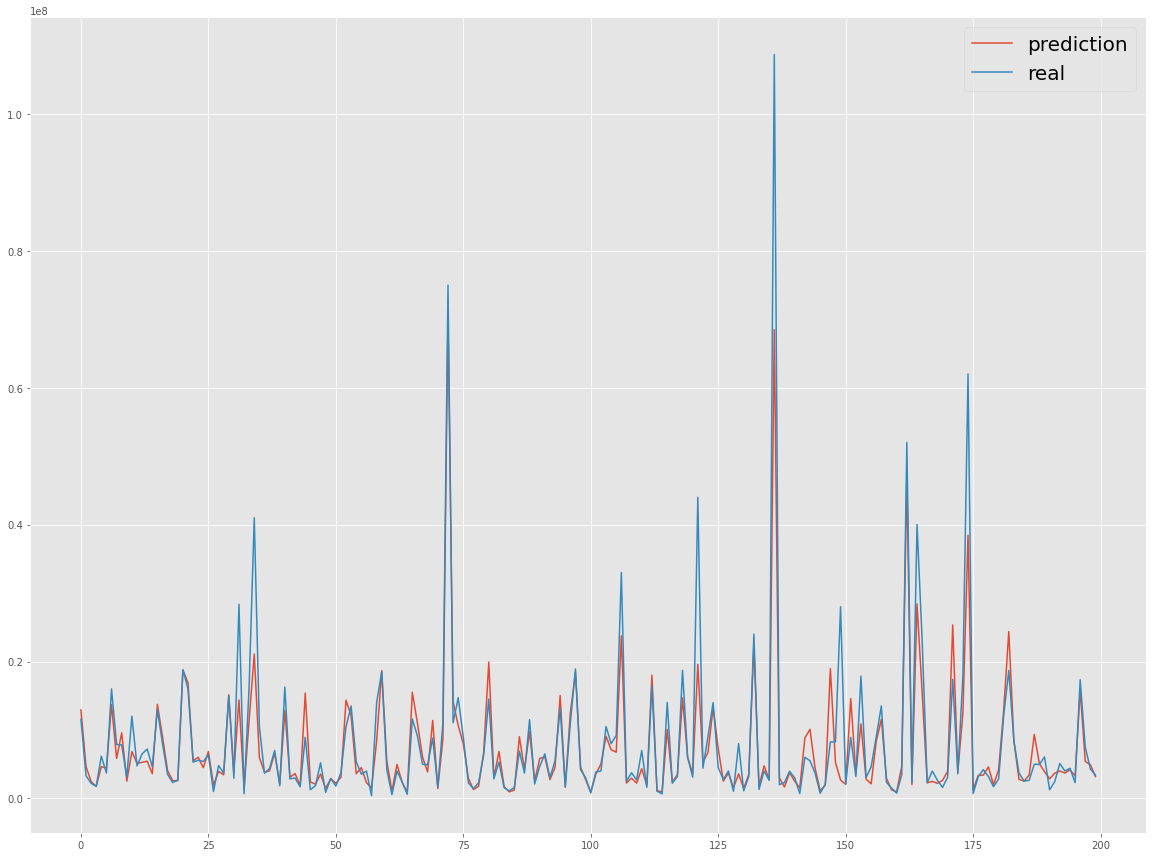

In [300]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(np.exp(oof_val_preds)[600:800], label = 'prediction')
plt.plot(np.exp(y)[600:800], label = 'real')
plt.legend(fontsize = 20)
plt.show()

In [301]:
ngb_valid_preds = oof_val_preds
ngb_preds = oof_test_preds

In [302]:
ens = np.exp((rf_valid_preds+ridge_valid_preds+xgb_valid_preds+lgb_valid_preds+gb_valid_preds+ngb_valid_preds)/6)

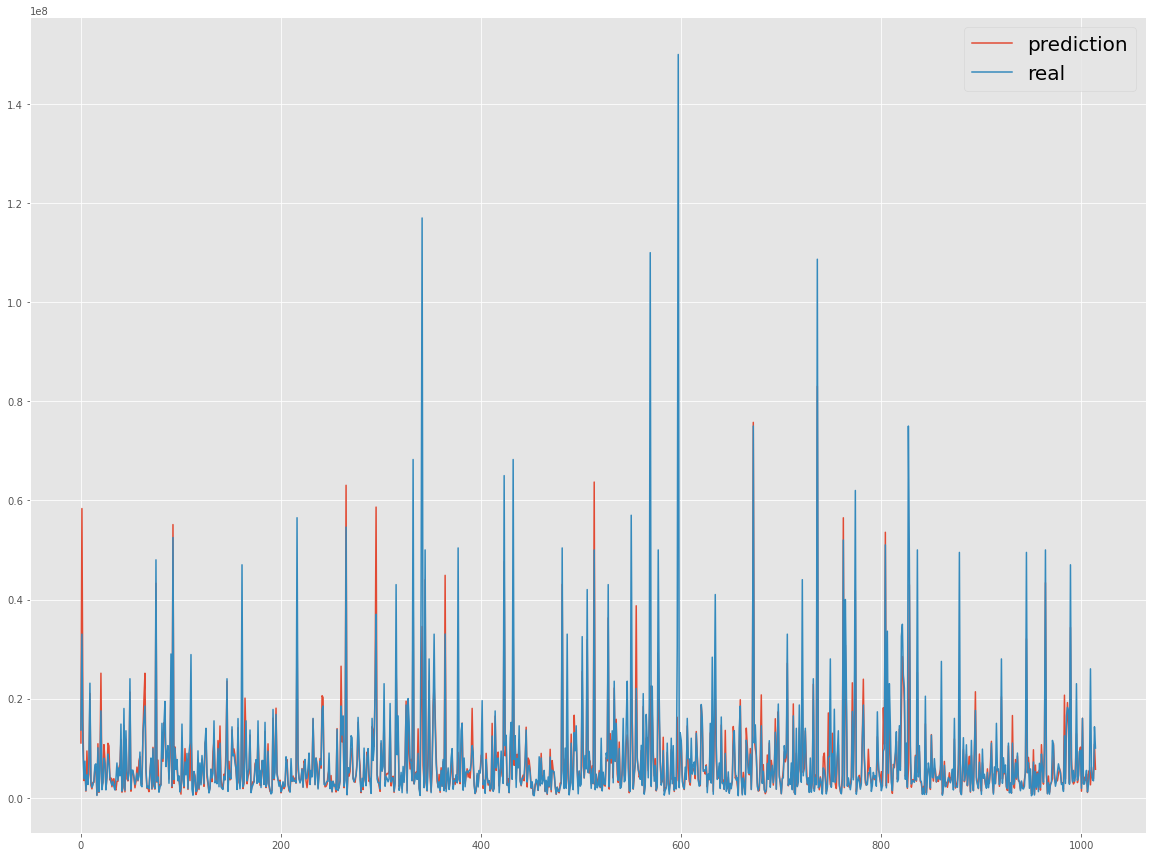

In [303]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(ens, label = 'prediction')
plt.plot(np.exp(y), label = 'real')
plt.legend(fontsize = 20)
plt.show()

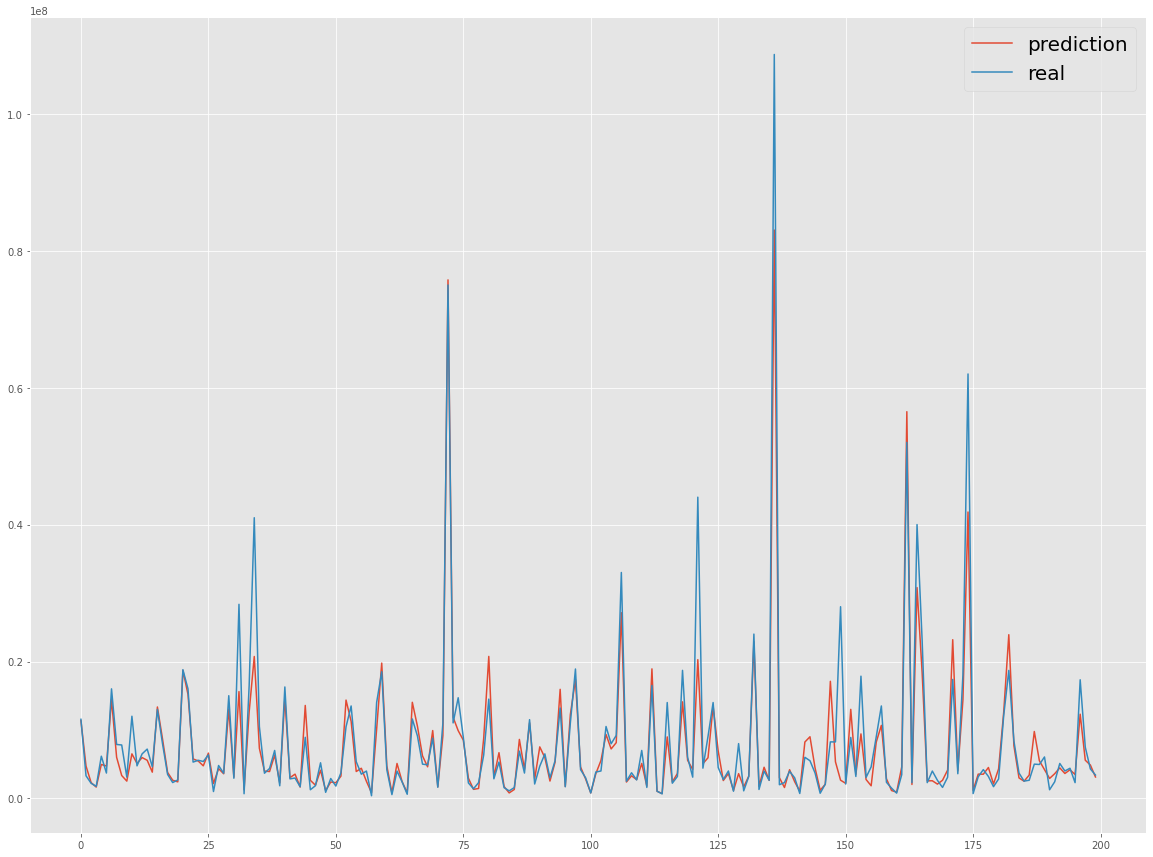

In [304]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(ens[600:800], label = 'prediction')
plt.plot(np.exp(y)[600:800], label = 'real')
plt.legend(fontsize = 20)
plt.show()

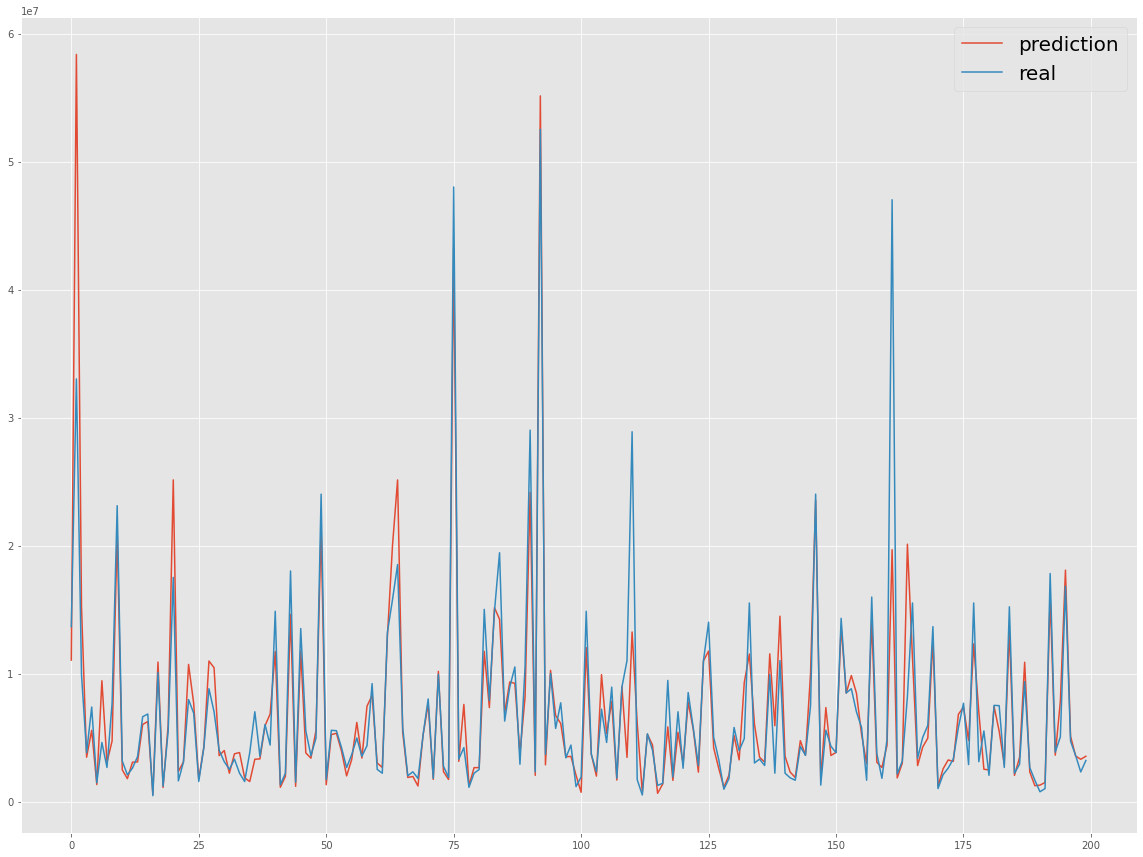

In [309]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(ens[0:200], label = 'prediction')
plt.plot(np.exp(y)[0:200], label = 'real')
plt.legend(fontsize = 20)
plt.show()

## Final

In [305]:
ens_test = np.exp((rf_preds+ridge_preds+xgb_preds+\
                   lgb_preds+gb_preds+ngb_preds)/6)

In [306]:
submission['target'] = ens_test
submission.to_csv('submission.csv')

In [307]:
pd.read_csv('submission.csv')

,id,target
0,0,1.928484e+07
1,1,4.933242e+06
2,2,6.333922e+06
3,3,1.133792e+06
4,4,2.543022e+06
...,...,...
431,431,1.077209e+07
432,432,5.097886e+06
433,433,8.740375e+06
434,434,3.112309e+06
